# COVID Simulator - Return to Office

## Introduction

The model will be based on discrete simulation with agents (people/employees) who can go through several states based on the SEIR model which is a model with the following states:
* susceptible state: person can be infected 
* exposed : person is exposed and has a risk of being infected
* infected: person is infected
* recovered / fatal: person has recovered or passed away

The model is based on the assumption that once recovered a person can not be infected again.

Key states, variables and distribution for the simulation are:

- Agents (N) = number of agents (employees) [integer]
- Days (D) = number of days [integer]
- Susceptible Agents (SA) = probability (part of population) agent will be susceptible for the virus [probability, Uniform Distribution]
- Pre-Infected Agents = number of agents (employees) who are infected, but not aware
- Interactions (I_lambda) = number of interactions sampled for each agent, each day [lambda, Poisson Distribution]
- Interaction Agent (IA) = interaction is limited to one to one interactions, not taken into account group gatherings, etc., hence single interaction with a single agent in the population with equal probability [Agents (N), uniform distribution]<br>
<b>NOTE:</b> Interaction is also not necessarily 'personal' interaction between two agents, it can be 'surface' interaction, e.g Agent A touches door handle and Agent B touches door handle almost immediately after Agent A.<br>
- Interaction Mistake (IM) = probability that agent A was not uncareful [probability, Uniform Distribution]. Agent A only gets infected when this interaction was with an infected agent B. This is one-way only, if agent B was not careful, agent A will not be infected.
- Agent Exposed (AE) = agent is exposed but not yet a carrier. In simulation it is assumed Infected Agent will start infecting others only the next day
- Home Infections (HI) = probability agent get infected between days at home [probability, Uniform Distribution].
- Agent Infected (AI) = agent is infected and will be infecting others during the incubation time
- Incubation Time Mean (IT_mean) = mean of the time before infection is detected and agent is isolated from population (agents), [mean - Incubation Time]
- Incubation Time Standard Deviation (IT_sd) = standard deviation of the time before infection is detected and agent is isolated from population (home or hospital) [standard deviation - Incubation Time]
- RecoveryTime (RT) = lambda for recovery time [lambda, Exponential Distribution]
- FatalityRate (FR) = probability infection is fatal [probability, Uniform Distribution]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Set Simulation Variables

In [4]:
# initialize variables
NumberOfAgents = 200
NumberOfDays = 365
ProbabilitySusceptible = 95
PreInfectedAgents = 10
LambdaInteractions = 10
ProbabilityInteractionAgent = NumberOfAgents
ProbabilityUnsafeInteraction = 2
ProbabilityHomeInfections = 0.3
MeanIncubationTime = 14
StandardDeviationIncubationTime = 2
LambdaRecoveryTime = 30
ProbabilityFatality = 1.5
NumberOfSimulationRuns = 10

## Step 2: Create Agent Records

Agent records will hold statistics and track the states of every individual agent for the simulation run.

In [5]:
def create_agent_records(NumberOfAgents,
                         ProbabilitySusceptible,
                         PreInfectedAgents,
                         MeanIncubationTime, # Incubation time is preset only used when infection occurs
                         StandardDeviationIncubationTime,
                         LambdaRecoveryTime, # Recovery time is preset only used when infection occurs
                         ProbabilityFatality # If fatal is true, recovery time is not considered, agent is inactive permanently
                        ):
    
    df_columns = ['id','active', 'susceptible', 
                  'infected', 'incubation_time', 'isolation_day',
                  'isolated', 'recovery_time', 'recovery_day',
                  'recovered', 'fatal']
    
    # Create agent records in DataFrame
    record_list = []
    for i in range (NumberOfAgents):
        agent_id = i
        agent_active = True
        agent_susceptible = (np.random.uniform(0, 100) <= ProbabilitySusceptible) # True or False susceptible
        agent_infected = (i+1 <= PreInfectedAgents) # True or False already infected day one
        agent_incubation_time = int(np.random.normal(MeanIncubationTime, StandardDeviationIncubationTime))
        agent_isolation_day = 0
        if agent_infected:
            agent_isolation_day = agent_incubation_time
        agent_isolated = False
        agent_recovery_time = int(np.random.exponential(LambdaRecoveryTime))
        agent_recovery_day = 0
        agent_recovered = False
        agent_fatal = (np.random.uniform(0, 100) <= ProbabilityFatality) # True or False fatal
        agent_record = [agent_id, agent_active, agent_susceptible,
                        agent_infected, agent_incubation_time, agent_isolation_day,
                        agent_isolated, agent_recovery_time, agent_recovery_day,
                        agent_recovered, agent_fatal
                       ]
        record_list.append(agent_record)
    df_agent_records = pd.DataFrame(record_list, columns=df_columns)
    return df_agent_records


In [6]:
df_agent_records = create_agent_records(NumberOfAgents = NumberOfAgents,
                                         ProbabilitySusceptible = ProbabilitySusceptible,
                                         PreInfectedAgents = PreInfectedAgents,
                                         MeanIncubationTime = MeanIncubationTime, 
                                         StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                         LambdaRecoveryTime = LambdaRecoveryTime,
                                         ProbabilityFatality = ProbabilityFatality
                                        )

In [8]:
df_agent_records.head()

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,False,True,11,11,False,27,0,False,False
1,1,True,True,True,16,16,False,31,0,False,False
2,2,True,True,True,18,18,False,3,0,False,False
3,3,True,True,True,14,14,False,16,0,False,False
4,4,True,True,True,18,18,False,22,0,False,False


## Step 3: Run Simulation

Few Assumptions for simulation runs:
1. If agent is inactive or isolated, it will still be drawn in the interaction pool, but will be discarded, this compensates that if less people are at work the interactions will also diminish
2. If agent recovered, agent can not be infected again and can not be a carrier
3. Interactions that lead to infection are the ones an uninfected agent has with an infected agent and made an interaction mistake

In [9]:
def simulate_agent_infected(df_agent_records, agent_id, 
                            ProbabilityHomeInfections, LambdaInteractions, 
                            NumberOfAgents, ProbabilityUnsafeInteraction
                           ):
    agent_infected = False
    
    # agent infected at home?
    agent_infected = (np.random.uniform(0, 100) <= ProbabilityHomeInfections)
    #print("home infected: ", agent_infected) # DEBUG
    
    # agent infected during interactions?
    number_of_interactions = int(np.random.poisson(LambdaInteractions)) # number of interactions
    agents_interactions_list = [int(x) for x in np.random.uniform(0, NumberOfAgents, number_of_interactions)] # agents
    infect_interactions_list = [1 if df_agent_records.infected[x] else 0 for x in agents_interactions_list] # infected agents
    unsafe_interactions_list = [1 if x <= ProbabilityUnsafeInteraction else 0 for 
                                x in np.random.uniform(0, 100, number_of_interactions)] # unsafe interactions
    result_list = [a and b for a, b in zip(infect_interactions_list, unsafe_interactions_list)] # cross infected and unsafe
    
    if sum(result_list):
        agent_infected = True
        
    # DEBUG: and explanation, see results
    #print(agents_interactions_list)
    #print(infect_interactions_list)
    #print(unsafe_interactions_list)
    #print(result_list)
   
    return agent_infected


In [10]:
## DEBUG: Simulate Function for testing
#simulate_agent_infected(df_agent_records=df_agent_records, agent_id=1, 
#                        ProbabilityHomeInfections=ProbabilityHomeInfections, 
#                        LambdaInteractions=LambdaInteractions,
#                        NumberOfAgents=NumberOfAgents,
#                        ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
#                       )

In [11]:
def simulate_day(NumberOfAgents, day_number, df_agent_records, 
                 ProbabilityHomeInfections, LambdaInteractions, 
                 ProbabilityUnsafeInteraction):
    # Check each agent
    df_agent_records_today = df_agent_records.copy()
    for i in range(NumberOfAgents):
        # 1. Agent Inactive or recovered, no actions
        if ((not df_agent_records_today.active[i]) 
            or (df_agent_records_today.recovered[i]) 
            or (not df_agent_records_today.susceptible[i])):
            continue
        
        # 2. Agent in Isolation, check if recovery is due
        if df_agent_records_today.isolated[i]:
            if (df_agent_records.recovery_day[i] == day_number):
                # data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100
                df_agent_records_today.loc[df_agent_records_today.id == i, 'recovered'] = True
                df_agent_records_today.loc[df_agent_records_today.id == i, 'isolated'] = False
            continue
        
        # 3. Agent is Infected, check if isolation is due
        if df_agent_records_today.infected[i]:
            if (df_agent_records_today.isolation_day[i] == day_number):
                # check fatality
                if df_agent_records_today.fatal[i]:
                    df_agent_records_today.loc[df_agent_records_today.id == i, 'active'] = False
                    # no longer infection threat as agent isolated from employees
                df_agent_records_today.loc[df_agent_records_today.id == i, 'isolated'] = True
                df_agent_records_today.loc[df_agent_records_today.id == i, 'infected'] = False
                recovery_day = df_agent_records_today.recovery_time[i] + day_number
                df_agent_records_today.loc[df_agent_records_today.id == i, 'recovery_day'] = recovery_day
                
            continue
            
        # 4. Agent is healty, simulate day
        agent_infected = simulate_agent_infected(df_agent_records=df_agent_records, # send previous day record!
                                                 agent_id=i, 
                                                 ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                                 LambdaInteractions=LambdaInteractions,
                                                 NumberOfAgents=NumberOfAgents,
                                                 ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                                                ) 
    
        if agent_infected:
            df_agent_records_today.loc[df_agent_records_today.id == i, 'infected'] = True
            isolation_day = df_agent_records_today.incubation_time[i] + day_number
            df_agent_records_today.loc[df_agent_records_today.id == i, 'isolation_day'] = isolation_day
            
        #print(i, df_agent_records_today.head())
    return df_agent_records_today # todays record

In [12]:
# DEBUG: Function Testing
simulate_day(NumberOfAgents=NumberOfAgents, day_number=1, df_agent_records=df_agent_records,
                 ProbabilityHomeInfections=ProbabilityHomeInfections, LambdaInteractions=LambdaInteractions, 
                 ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,False,True,11,11,False,27,0,False,False
1,1,True,True,True,16,16,False,31,0,False,False
2,2,True,True,True,18,18,False,3,0,False,False
3,3,True,True,True,14,14,False,16,0,False,False
4,4,True,True,True,18,18,False,22,0,False,False
5,5,True,True,True,13,13,False,7,0,False,False
6,6,True,True,True,17,17,False,3,0,False,False
7,7,True,True,True,19,19,False,25,0,False,False
8,8,True,True,True,18,18,False,52,0,False,False
9,9,True,True,True,14,14,False,15,0,False,True


In [13]:
def simulation_run(NumberOfDays = NumberOfDays,
                   NumberOfAgents = NumberOfAgents,
                   ProbabilitySusceptible = ProbabilitySusceptible,
                   PreInfectedAgents = PreInfectedAgents,
                   MeanIncubationTime = MeanIncubationTime, 
                   StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                   LambdaRecoveryTime = LambdaRecoveryTime,
                   ProbabilityFatality = ProbabilityFatality,
                   ProbabilityHomeInfections=ProbabilityHomeInfections, 
                   LambdaInteractions=LambdaInteractions, 
                   ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                  ):
    # Create Agent Records
    df_agent_records = create_agent_records(NumberOfAgents = NumberOfAgents,
                                         ProbabilitySusceptible = ProbabilitySusceptible,
                                         PreInfectedAgents = PreInfectedAgents,
                                         MeanIncubationTime = MeanIncubationTime, 
                                         StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                         LambdaRecoveryTime = LambdaRecoveryTime,
                                         ProbabilityFatality = ProbabilityFatality
                                        )
    # Simulate number of days
    df_agent_records_today = df_agent_records.copy()
    sim_days_list = []
    sim_days_list.append(df_agent_records_today)
    for day_number in range(1, NumberOfDays+1): #starting day 1
        df_agent_records_today = simulate_day(NumberOfAgents=NumberOfAgents, 
                                              day_number=day_number, 
                                              df_agent_records=df_agent_records_today,
                                              ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                              LambdaInteractions=LambdaInteractions, 
                                              ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)
    
        sim_days_list.append(df_agent_records_today)
    return sim_days_list

In [ ]:
simulation_run(NumberOfDays = NumberOfDays,
                   NumberOfAgents = NumberOfAgents,
                   ProbabilitySusceptible = ProbabilitySusceptible,
                   PreInfectedAgents = PreInfectedAgents,
                   MeanIncubationTime = MeanIncubationTime, 
                   StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                   LambdaRecoveryTime = LambdaRecoveryTime,
                   ProbabilityFatality = ProbabilityFatality,
                   ProbabilityHomeInfections=ProbabilityHomeInfections, 
                   LambdaInteractions=LambdaInteractions, 
                   ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                  )

### Full Simulation

In [15]:
# initialize variables
NumberOfAgents = 200
NumberOfDays = 365
ProbabilitySusceptible = 95
PreInfectedAgents = 10
LambdaInteractions = 10
ProbabilityInteractionAgent = NumberOfAgents
ProbabilityUnsafeInteraction = 2
ProbabilityHomeInfections = 0.3
MeanIncubationTime = 14
StandardDeviationIncubationTime = 2
LambdaRecoveryTime = 30
ProbabilityFatality = 1.5
NumberOfSimulationRuns = 10

In [16]:
def full_simulation(NumberOfDays = NumberOfDays,
                    NumberOfAgents = NumberOfAgents,
                    NumberOfSimulationRuns = NumberOfSimulationRuns,
                    ProbabilitySusceptible = ProbabilitySusceptible,
                    PreInfectedAgents = PreInfectedAgents,
                    MeanIncubationTime = MeanIncubationTime, 
                    StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                    LambdaRecoveryTime = LambdaRecoveryTime,
                    ProbabilityFatality = ProbabilityFatality,
                    ProbabilityHomeInfections=ProbabilityHomeInfections, 
                    LambdaInteractions=LambdaInteractions, 
                    ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction):
    simulation_list = []
    for i in range(NumberOfSimulationRuns):
        print("Simulation Run: ", i)
        sim_days_list = simulation_run(NumberOfDays = NumberOfDays,
                                       NumberOfAgents = NumberOfAgents,
                                       ProbabilitySusceptible = ProbabilitySusceptible,
                                       PreInfectedAgents = PreInfectedAgents,
                                       MeanIncubationTime = MeanIncubationTime, 
                                       StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                       LambdaRecoveryTime = LambdaRecoveryTime,
                                       ProbabilityFatality = ProbabilityFatality,
                                       ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                       LambdaInteractions=LambdaInteractions, 
                                       ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                                      )
        simulation_list.append(sim_days_list)
    return simulation_list

In [17]:
simulation_results =full_simulation(NumberOfDays = NumberOfDays,
                                    NumberOfAgents = NumberOfAgents,
                                    NumberOfSimulationRuns = NumberOfSimulationRuns,
                                    ProbabilitySusceptible = ProbabilitySusceptible,
                                    PreInfectedAgents = PreInfectedAgents,
                                    MeanIncubationTime = MeanIncubationTime, 
                                    StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                    LambdaRecoveryTime = LambdaRecoveryTime,
                                    ProbabilityFatality = ProbabilityFatality,
                                    ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                    LambdaInteractions=LambdaInteractions, 
                                    ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)

Simulation Run:  0
Simulation Run:  1
Simulation Run:  2
Simulation Run:  3
Simulation Run:  4
Simulation Run:  5
Simulation Run:  6
Simulation Run:  7
Simulation Run:  8
Simulation Run:  9


## Step 4: Analytics and Visualization

### Check Single Days

In [18]:
simulation_results[0][223]

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,True,False,15,15,False,16,31,True,False
1,1,True,True,False,16,16,False,20,36,True,False
2,2,True,True,False,10,10,False,76,86,True,False
3,3,True,True,False,17,17,False,8,25,True,False
4,4,True,True,False,15,15,False,55,70,True,False
5,5,True,True,False,11,11,False,93,104,True,False
6,6,True,True,False,15,15,False,66,81,True,False
7,7,True,True,False,12,12,False,17,29,True,False
8,8,True,True,False,15,15,False,49,64,True,False
9,9,True,True,False,15,15,False,4,19,True,False


### Single Run Example

In [19]:
def count_column_boolean(df_list, column_name):
    true_count_list = []
    for i in range(len(df_list)):
        df = df_list[i]
        true_count = df[column_name].sum()
        true_count_list.append(true_count)
    return true_count_list  

In [30]:
# Single Run Example
df_list = simulation_results[5] # chose a simulation result
number_days = len(df_list)
x1 = list(range(0, number_days))
tc_active = count_column_boolean(df_list=df_list, column_name='active')
tc_infected = count_column_boolean(df_list=df_list, column_name='infected')
tc_isolated = count_column_boolean(df_list=df_list, column_name='isolated')
tc_recovered = count_column_boolean(df_list=df_list, column_name='recovered')
tc_fatal = [NumberOfAgents-x for x in tc_active]
tc_workforce_inactive = [x + y for x, y in zip(tc_isolated, tc_fatal)]
tc_workforce_active = [NumberOfAgents-x for x in tc_workforce_inactive]

In [31]:
# Check / Debug
print(x1)
print(tc_active)
print(tc_infected)
print(tc_isolated)
print(tc_recovered)
print(tc_fatal)
print(tc_workforce_inactive)
print(tc_workforce_active)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [32]:
# Set Font Size for Plotting
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15,15]

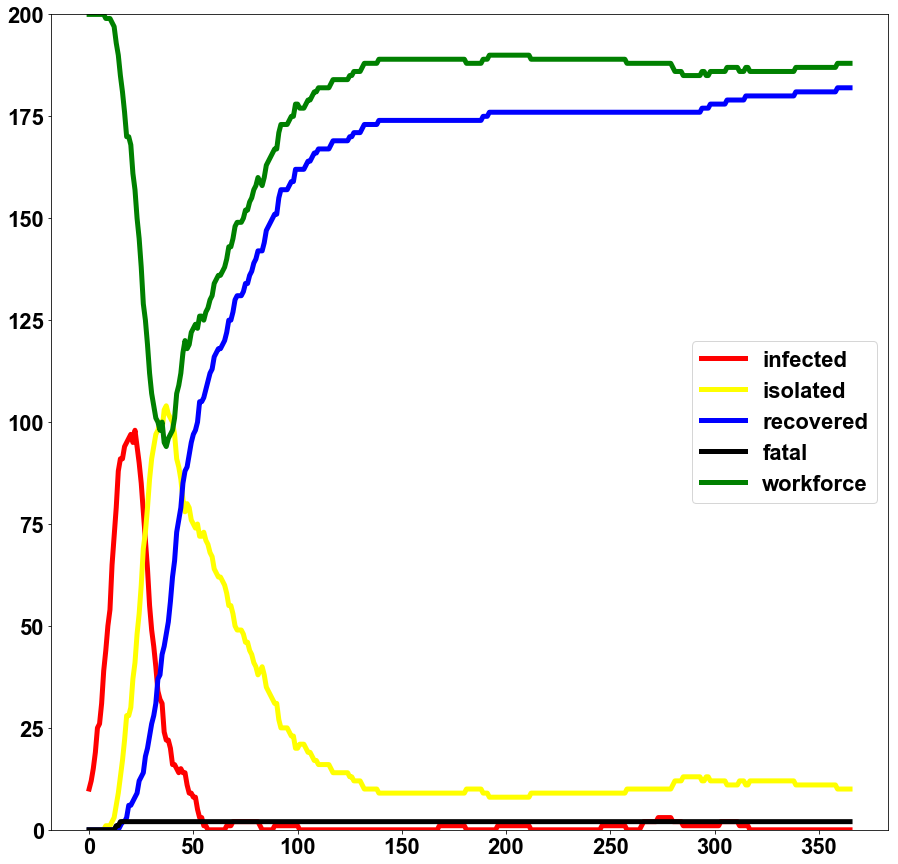

In [33]:
# Plot the data
# Prepare the data
x = x1
y1 = tc_infected
y2 = tc_isolated
y3 = tc_recovered
y4 = tc_fatal
y5 = tc_workforce_active
plt.ylim(top = NumberOfAgents, bottom = 0)
y_ticks = range(NumberOfAgents+1)
#plt.subplot(1, 4, 4)
plt.ylim(top = NumberOfAgents, bottom = 0)
#plt.yticks(y_ticks)
plt.plot(x, y1, label='infected', lw=5.0, color='red')
plt.plot(x, y2, label='isolated', lw=5.0, color='yellow')
plt.plot(x, y3, label='recovered', lw=5.0, color='blue')
plt.plot(x, y4, label='fatal', lw=5.0, color='black')
plt.plot(x, y5, label='workforce', lw=5.0, color='green')
plt.legend()
# Show the plots
plt.show()